In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import numpy.ma as ma
from dateutil.rrule import rrule, MONTHLY
import collections
from tqdm import tqdm
from global_land_mask import globe
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.cm import get_cmap

## Read in data, define and assign times to available data 

In [3]:
fn = 'C:/Users/Owner/Documents/Thesis/Code/Data_Extraction/EKF_Data_Extraction/EKF400_ens_mem_Mean_v2.0/EKF400_ens_mem_Mean_v2.0_COMBINED.nc'
#fn = 'C:\\Users\Owner\Documents\Thesis\Data Collection\Raw Data\EKF400_ens_mem_Mean_v2.0\EKF400_ens_mem_Mean_v2.0_COMBINED.nc'
ds = nc.Dataset(fn)

data = xr.open_dataset(fn)

In [4]:
data

<xarray.Dataset>
Dimensions:                              (latitude: 96, longitude: 192, pressure_level_gph: 2, pressure_level_wind: 2, time: 3024)
Coordinates:
  * time                                 (time) object 1611-01-16 00:00:00 .....
  * longitude                            (longitude) float64 0.0 1.875 ... 358.1
  * latitude                             (latitude) float64 88.57 ... -88.57
  * pressure_level_gph                   (pressure_level_gph) float64 500.0 1...
  * pressure_level_wind                  (pressure_level_wind) float64 850.0 ...
Data variables:
    air_temperature                      (time, latitude, longitude) float32 ...
    total precipitation                  (time, latitude, longitude) float32 ...
    air_pressure_at_sea_level            (time, latitude, longitude) float32 ...
    geopotential_height                  (time, pressure_level_gph, latitude, longitude) float32 ...
    eastward_wind                        (time, pressure_level_wind, latitude, longitude) float32 ...
    northward_wind                       (time, pressure_level_wind, latitude, longitude) float32 ...
    lagrangian_tendency_of_air_pressure  (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Mon Jun 15 14:00:25 2020: cdo delname,blocks,cycfreq EKF400...
    source:       ECHAM5.4
    institution:  University of Bern
    title:        EKF400
    references:   Franke et al., 2017
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [5]:
time = ds.variables['time']

full_date_list = [30*x for x in range(0,4715+1)] #Iterature through a list with maximum admissible number of months

time_array = ma.MaskedArray.tolist(time[:]) #Extract MaskedArray time elements from NetCDF file

print(f'The total possible time periods are {len(full_date_list)}') #Theoretical full number of periods of data

missing_dates = [] #List of time periods where there is a data point missing (days since start_date)
missing_date_list_position = [] #index position of the missing data point in the full_date_list
for i in full_date_list:
    if i in time_array:
        pass
    else:
        #print(i)
        missing_dates.append(i)
        missing_date_list_position.append(int((i/30))) #find the missing position 

populated_date_list_position = [] #index position of the missing data point in the full_date_list
for i in full_date_list:
    if i in time_array:
        populated_date_list_position.append(int((i/30))) #find the missing position
    else:
        pass

start_date = datetime.datetime(1611,1,16) #Start date of the dataset
date_list = list(rrule(freq=MONTHLY, count=len(full_date_list),dtstart=start_date)) #Populate a datetime formatted list of dates between the reference dates
all_dates = list(rrule(freq=MONTHLY, count=len(full_date_list),dtstart=start_date))

final_times_all = [] #List of all dates in the data in string dd-mm-yyyy format
for i in all_dates:
    final_times_all.append(i.strftime('%d-%m-%Y'))

#Delete full_date_list elements off that correspond to missing_date entries
for i in sorted(missing_date_list_position,reverse=True):
    del date_list[i] #THIS IS NOW THE LIST OF DATES ONLY WHICH DATA EXISTS FOR
    
if len(date_list) == len(time):
    print(f'The total number of dates that have data are correct, with {len(date_list)}')
    
final_time_data = [] #List of all dates in the data from which data exists for in string dd-mm-yyyy format
for i in date_list:
    final_time_data.append(i.strftime('%d-%m-%Y'))
    
unavailable_dates = list(rrule(freq=MONTHLY, count=len(full_date_list),dtstart=start_date)) #Initialize list for all dates that data does not exist for
date_no_data=list(set(unavailable_dates).difference(date_list))
date_no_data.sort()
if len(date_no_data) == len(full_date_list) - len(time):
    print(f'The number of dates that have no data are correct, with {len(date_no_data)}')
    
final_time_no_data = [] #List of all dates in the data from which no data exists for in string dd-mm-yyyy format
for i in date_no_data:
    final_time_no_data.append(i.strftime('%d-%m-%Y'))

C:\Users\Owner\AppData\Local\Temp\ipykernel_31476\433410927.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time_array = ma.MaskedArray.tolist(time[:]) #Extract MaskedArray time elements from NetCDF file


The total possible time periods are 4716
The total number of dates that have data are correct, with 3024
The number of dates that have no data are correct, with 1692


## Filter data collection sites to LAND/OCEAN 

###### land_coords
###### land_indices

###### ocean_coords
###### ocean_indices

In [7]:
longitude = ds.variables['longitude']
latitude = ds.variables['latitude']

latitude_unmask = ma.MaskedArray.tolist(latitude[:]) #Create array of latitude values length 96
lon = [x-180 for x in ds.variables['longitude'][:]] #Create array of transformed longitude values length 192

# Make lists for values that return TRUE
land_list_lat = []
land_list_lon = []

# Make lists for values that return FALSE
ocean_list_lat = []
ocean_list_lon = []

for i in latitude_unmask:
    for j in lon:
        if globe.is_land(i,j)==True:
            land_list_lat.append(i)
            land_list_lon.append(j)
        else:
            ocean_list_lat.append(i)
            ocean_list_lon.append(j)
            
land_coords = list(zip(land_list_lat,land_list_lon)) # Create (latitude,longitude) pairs for all land coordinates
ocean_coords = list(zip(ocean_list_lat,ocean_list_lon)) # Create (latitude,longitude) pairs for all ocean coordinates
world_coords = land_coords + ocean_coords

#print(f'The total number of data points collected on land is {len(land_list_lat)}')
#print(f'The total number of data points collected in the ocean is {len(ocean_list_lat)}')

#Create dictionary with each latitude value corresponding to index value
latitude_dict = dict(zip([x for x in range(len(latitude_unmask))],latitude_unmask)) #These are correct
longitude_dict = dict(zip([x for x in range(len(lon))],lon)) #These are also correct according to the sorting of the lists

land_lat_indices = []
land_lon_indices = []

ocean_lat_indices = []
ocean_lon_indices = []

for i in land_list_lat:
    land_lat_indices.append(list(latitude_dict.keys())[list(latitude_dict.values()).index(i)])
    
for i in land_list_lon:
    land_lon_indices.append(list(longitude_dict.keys())[list(longitude_dict.values()).index(i)])
    
for i in ocean_list_lat:
    ocean_lat_indices.append(list(latitude_dict.keys())[list(latitude_dict.values()).index(i)])
    
for i in ocean_list_lon:
    ocean_lon_indices.append(list(longitude_dict.keys())[list(longitude_dict.values()).index(i)])

world_list_lat = land_list_lat+ocean_list_lat
world_list_lon = land_list_lon+ocean_list_lon

land_indices = list(zip(land_lat_indices,land_lon_indices))
ocean_indices = list(zip(ocean_lat_indices,ocean_lon_indices))
world_indices = land_indices + ocean_indices

land_total = list(zip(land_lat_indices,land_lon_indices,land_list_lat,land_list_lon))
ocean_total = list(zip(ocean_lat_indices,ocean_lon_indices,ocean_list_lat,ocean_list_lon))

land = pd.DataFrame(land_total,columns=['Latitude Index','Longitude Index','Latitude','Longitude'])
land_index=land.index
land_index.name='Land Measurements'

ocean = pd.DataFrame(ocean_total,columns=['Latitude Index','Longitude Index','Latitude','Longitude'])
ocean_index=ocean.index
ocean_index.name='Ocean Measurements'

print(land)
print(ocean)

C:\Users\Owner\AppData\Local\Temp\ipykernel_31476\947201901.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latitude_unmask = ma.MaskedArray.tolist(latitude[:]) #Create array of latitude values length 96
C:\Users\Owner\AppData\Local\Temp\ipykernel_31476\947201901.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = [x-180 for x in ds.varia

                   Latitude Index  Longitude Index  Latitude  Longitude
Land Measurements                                                      
0                               3               55     83.00    -76.875
1                               3               56     83.00    -75.000
2                               3               57     83.00    -73.125
3                               3               58     83.00    -71.250
4                               3               59     83.00    -69.375
...                           ...              ...       ...        ...
6078                           95              187    -88.57    170.625
6079                           95              188    -88.57    172.500
6080                           95              189    -88.57    174.375
6081                           95              190    -88.57    176.250
6082                           95              191    -88.57    178.125

[6083 rows x 4 columns]
                    Latitude Index  Lon

In [8]:
# Export
#land.to_csv('land_coords.csv')
#ocean.to_csv('ocean_coords.csv')

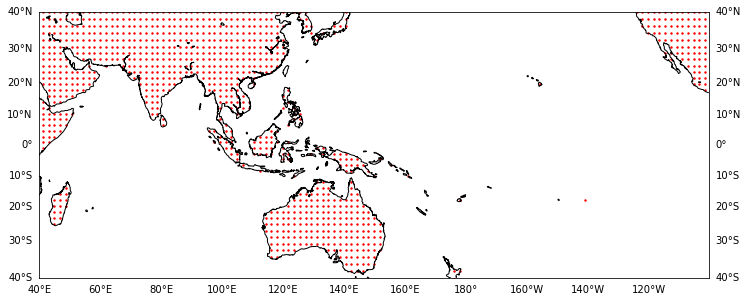

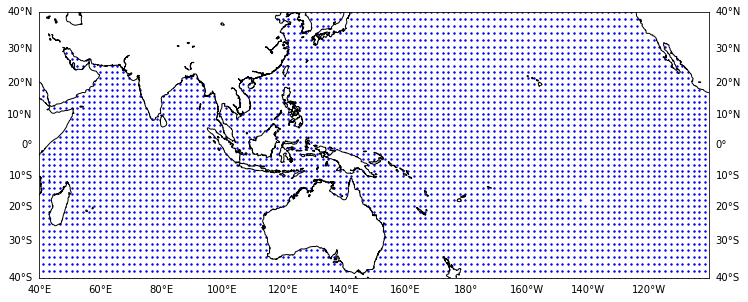

In [9]:
plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(land_list_lon,land_list_lat,latlon=True,s=2,c='red')

plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,41.,10.),labels=[True,True,False,False],dashes=[2,2], linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2], linewidth=0.0)
m.scatter(ocean_list_lon,ocean_list_lat,latlon=True,s=2,c='blue')

## Assign time series based on individual ocean/land observations 

In [12]:
air_temp = ds.variables['air_temperature'][:]
total_prec = ds.variables['total precipitation'][:]

# Filter by data existing on land

#Air temperature data
def land_air_temp():
    air_temp_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES... 
    for (i,j) in land_indices:
        air_temp_filter.append(air_temp[:,i,j])
    
    unmask_air_temp_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES...
    for i in range(len(air_temp_filter)):
        unmask_air_temp_filter.append(ma.MaskedArray.tolist(air_temp_filter[i]))
    
    time_series_air_temp = []
    for i in tqdm(range(len(unmask_air_temp_filter))):
        dict1 = dict(zip(populated_date_list_position,unmask_air_temp_filter[i]))
        dict2 = dict(zip(missing_date_list_position,[np.nan for x in range(len(final_time_no_data))]))
        dict_com = dict1.copy()
        dict_com.update(dict2)
        dict_fin = collections.OrderedDict(sorted(dict_com.items()))
        time_series_air_temp.append(list(dict_fin.values()))
        
    land_lat_lon_airtemp = list(zip(land_list_lat,land_list_lon,time_series_air_temp))
    
    return land_lat_lon_airtemp

def ocean_air_temp():
    air_temp_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES... 
    for (i,j) in ocean_indices:
        air_temp_filter.append(air_temp[:,i,j])
    
    unmask_air_temp_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES...
    for i in range(len(air_temp_filter)):
        unmask_air_temp_filter.append(ma.MaskedArray.tolist(air_temp_filter[i]))
    
    time_series_air_temp = []
    for i in tqdm(range(len(unmask_air_temp_filter))):
        dict1 = dict(zip(populated_date_list_position,unmask_air_temp_filter[i]))
        dict2 = dict(zip(missing_date_list_position,[np.nan for x in range(len(final_time_no_data))]))
        dict_com = dict1.copy()
        dict_com.update(dict2)
        dict_fin = collections.OrderedDict(sorted(dict_com.items()))
        time_series_air_temp.append(list(dict_fin.values()))
        
    ocean_lat_lon_airtemp = list(zip(ocean_list_lat,ocean_list_lon,time_series_air_temp))
    
    return ocean_lat_lon_airtemp

# Total precipitation data
def land_prec():
    prec_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES... 
    for (i,j) in land_indices:
        prec_filter.append(total_prec[:,i,j])
    
    unmask_prec_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES...
    for i in range(len(prec_filter)):
        unmask_prec_filter.append(ma.MaskedArray.tolist(prec_filter[i]))
    
    time_series_prec = []
    for i in tqdm(range(len(unmask_prec_filter))):
        dict1 = dict(zip(populated_date_list_position,unmask_prec_filter[i]))
        dict2 = dict(zip(missing_date_list_position,[np.nan for x in range(len(final_time_no_data))])) ## CHANGED FROM None to 0 16/03/22 so means can be calculated
        dict_com = dict1.copy()
        dict_com.update(dict2)
        dict_fin = collections.OrderedDict(sorted(dict_com.items()))
        time_series_prec.append(list(dict_fin.values()))
        
    land_lat_lon_prec = list(zip(land_list_lat,land_list_lon,time_series_prec))
    
    return land_lat_lon_prec

def ocean_prec():
    prec_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES... 
    for (i,j) in ocean_indices:
        prec_filter.append(total_prec[:,i,j])
    
    unmask_prec_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES...
    for i in range(len(prec_filter)):
        unmask_prec_filter.append(ma.MaskedArray.tolist(prec_filter[i]))
    
    time_series_prec = []
    for i in tqdm(range(len(unmask_prec_filter))):
        dict1 = dict(zip(populated_date_list_position,unmask_prec_filter[i]))
        dict2 = dict(zip(missing_date_list_position,[np.nan for x in range(len(final_time_no_data))]))
        dict_com = dict1.copy()
        dict_com.update(dict2)
        dict_fin = collections.OrderedDict(sorted(dict_com.items()))
        time_series_prec.append(list(dict_fin.values()))
        
    ocean_lat_lon_prec = list(zip(ocean_list_lat,ocean_list_lon,time_series_prec))
    
    return ocean_lat_lon_prec

def world_prec():
    prec_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES... 
    for (i,j) in world_indices:
        prec_filter.append(total_prec[:,i,j])
    
    unmask_prec_filter = [] #THIS LIST IS CORRECT AND RETURNS CORRECT VALUES...
    for i in range(len(prec_filter)):
        unmask_prec_filter.append(ma.MaskedArray.tolist(prec_filter[i]))
    
    time_series_prec = []
    for i in tqdm(range(len(unmask_prec_filter))):
        dict1 = dict(zip(populated_date_list_position,unmask_prec_filter[i]))
        dict2 = dict(zip(missing_date_list_position,[np.nan for x in range(len(final_time_no_data))]))
        dict_com = dict1.copy()
        dict_com.update(dict2)
        dict_fin = collections.OrderedDict(sorted(dict_com.items()))
        time_series_prec.append(list(dict_fin.values()))
        
    lat_lon_prec = list(zip(world_list_lat,world_list_lon,time_series_prec))
    
    return lat_lon_prec

C:\Users\Owner\AppData\Local\Temp\ipykernel_31476\3918926431.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  air_temp = ds.variables['air_temperature'][:]
C:\Users\Owner\AppData\Local\Temp\ipykernel_31476\3918926431.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  total_prec = ds.variables['total precipitation'][:]


In [13]:
input1 = list(zip(ocean_export[0],ocean_export[1],ocean_export[2]))

df1 = pd.DataFrame.from_records(input1,columns=['Latitude','Longitude','Total_Precipitation_Ocean'])

df2 = pd.DataFrame.from_records(land_export,columns=['Latitude','Longitude','Total_Precipitation_Land'])

#df1.to_csv('Total_Precip_Ocean.csv')
#df2.to_csv('Total_Precip_Land.csv')

NameError: name 'ocean_export' is not defined

In [14]:
land_export[0]

NameError: name 'land_export' is not defined

In [15]:
#Check
print(f'Latitude: {latitude[3]}')
print(f'Longitude: {lon[56]}')
print(len(air_temp[:,3,56]))

Latitude: 83.0
Longitude: -75.0
3024


C:\Users\Owner\AppData\Local\Temp\ipykernel_31476\1143051275.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(f'Latitude: {latitude[3]}')


## Filtering Data Based on Region

In [16]:
# From McRobie et al. the northwest Australian monson region is defined as 
# Latitude: -40 to 40
# Longitude: -140 to 80 

# The points of interest are
# NWAus (JJA): Lat(-10 to -20) Lon(115 to 140)
# NEAus (DJF):  Lat(-10 to -20) Lon(140 to 150)
# MC (DJF): Lat(-10 to 5) Lon(90-150) Maritime Continent
# IO (DJF): Lat(-15 to 0) Lon(45 to 60) Western Indian Continent
# ISM (DJF): Lat(5 to 25) Lon(70 to 100) Indian Summer Monsoon Region
# EASM (JJA): Lat (10 to 20) Lon(100 to 120) East Asian summer monsoon region -> Dot at 
# EEP (DJF): Lat(0-10) Lon(230 to 250) East Equatorial Pacific

average_lat = [np.mean([-10,-20]),np.mean([-10,-20]),np.mean([-10,5]),np.mean([-15,0]),np.mean([5,25]),np.mean([10,20]),np.mean([0,10])]
average_lon = [np.mean([115,140]),np.mean([140,150]),np.mean([90,150]),np.mean([45,60]),np.mean([70,100]),np.mean([100,120]),np.mean([230,250])]
annotations = ['NWAus','NEAus','MC','IO','ISM','EASM','EEP']

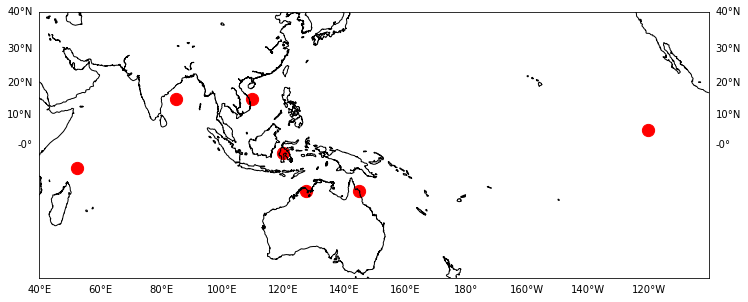

In [17]:
# Plot of sites in question

plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(average_lon,average_lat,latlon=True,s=150,c='red')

In [18]:
#Using land data

#Northwest Australia
nw_aus_land_coords = []
for (i,j) in land_coords:
    if -20.<=i<= -10. and 115.<=j<=140.:
        nw_aus_land_coords.append((i,j))

print(f'There are {len(nw_aus_land_coords)} land samples in the Northwest Australia box')
        
nw_aus_land_lat = []
nw_aus_land_lon = []
for (i,j) in nw_aus_land_coords:
    nw_aus_land_lat.append(i)
    nw_aus_land_lon.append(j)

#Northeast Australia
ne_aus_land_coords = []
for (i,j) in land_coords:
    if -20.<=i<= -10. and 140.<=j<=150.:
        ne_aus_land_coords.append((i,j))

print(f'There are {len(ne_aus_land_coords)} land samples in the Northeast Australia box')
        
ne_aus_land_lat = []
ne_aus_land_lon = []
for (i,j) in ne_aus_land_coords:
    ne_aus_land_lat.append(i)
    ne_aus_land_lon.append(j)

#Maritime Continent
mc_land_coords = []
for (i,j) in land_coords:
    if -10.<=i<= 5. and 90.<=j<=150.:
        mc_land_coords.append((i,j))

print(f'There are {len(mc_land_coords)} land samples in the Maritime Continent box')
        
mc_land_lat = []
mc_land_lon = []
for (i,j) in mc_land_coords:
    mc_land_lat.append(i)
    mc_land_lon.append(j)
    
# Western Indian Ocean
io_land_coords = []
for (i,j) in land_coords:
    if -15.<=i<= 0. and 45.<=j<=60.:
        io_land_coords.append((i,j))

print(f'There are {len(io_land_coords)} land samples in the Western Indian Ocean box')
        
io_land_lat = []
io_land_lon = []
for (i,j) in io_land_coords:
    io_land_lat.append(i)
    io_land_lon.append(j)
    
# Indian summer monsoon region
ism_land_coords = []
for (i,j) in land_coords:
    if 5.<=i<= 25. and 70.<=j<=100.:
        ism_land_coords.append((i,j))

print(f'There are {len(ism_land_coords)} land samples in the Indian summer monsoon box')
        
ism_land_lat = []
ism_land_lon = []
for (i,j) in ism_land_coords:
    ism_land_lat.append(i)
    ism_land_lon.append(j)
    
# East Asian summer monsoon region
easm_land_coords = []
for (i,j) in land_coords:
    if 10.<=i<= 20. and 100.<=j<=120.:
        easm_land_coords.append((i,j))

print(f'There are {len(easm_land_coords)} land samples in the East Asian summer monsoon box')
        
easm_land_lat = []
easm_land_lon = []
for (i,j) in easm_land_coords:
    easm_land_lat.append(i)
    easm_land_lon.append(j)
    
# East Equatorial Pacific
eep_land_coords = []
for (i,j) in land_coords:
    if 0.<=i<= 10. and -130.<=j<=-110.: #230-250 E is equivalent to 50-70W
        eep_land_coords.append((i,j))

print(f'There are {len(eep_land_coords)} land samples in the East Equatorial Pacific box')
        
eep_land_lat = []
eep_land_lon = []
for (i,j) in eep_land_coords:
    eep_land_lat.append(i)
    eep_land_lon.append(j)

There are 31 land samples in the Northwest Australia box
There are 12 land samples in the Northeast Australia box
There are 64 land samples in the Maritime Continent box
There are 1 land samples in the Western Indian Ocean box
There are 63 land samples in the Indian summer monsoon box
There are 23 land samples in the East Asian summer monsoon box
There are 0 land samples in the East Equatorial Pacific box


In [22]:
# Using ocean data

#Northwest Australia
nw_aus_ocean_coords = []
for (i,j) in ocean_coords:
    if -20.<=i<= -10. and 115.<=j<=140.:
        nw_aus_ocean_coords.append((i,j))

print(f'There are {len(nw_aus_ocean_coords)} ocean samples in the Northwest Australia box')
        
nw_aus_ocean_lat = []
nw_aus_ocean_lon = []
for (i,j) in nw_aus_ocean_coords:
    nw_aus_ocean_lat.append(i)
    nw_aus_ocean_lon.append(j)

#Northeast Australia
ne_aus_ocean_coords = []
for (i,j) in ocean_coords:
    if -20.<=i<= -10. and 140.<=j<=150.:
        ne_aus_ocean_coords.append((i,j))

print(f'There are {len(ne_aus_ocean_coords)} ocean samples in the Northeast Australia box')
        
ne_aus_ocean_lat = []
ne_aus_ocean_lon = []
for (i,j) in ne_aus_ocean_coords:
    ne_aus_ocean_lat.append(i)
    ne_aus_ocean_lon.append(j)

#Maritime Continent
mc_ocean_coords = []
for (i,j) in ocean_coords:
    if -10.<=i<= 5. and 90.<=j<=150.:
        mc_ocean_coords.append((i,j))

print(f'There are {len(mc_ocean_coords)} ocean samples in the Maritime Continent box')
        
mc_ocean_lat = []
mc_ocean_lon = []
for (i,j) in mc_ocean_coords:
    mc_ocean_lat.append(i)
    mc_ocean_lon.append(j)
    
# Western Indian Ocean
io_ocean_coords = []
for (i,j) in ocean_coords:
    if -15.<=i<= 0. and 45.<=j<=60.:
        io_ocean_coords.append((i,j))
print(f'There are {len(io_ocean_coords)} ocean samples in the Western Indian Ocean box')
        
io_ocean_lat = []
io_ocean_lon = []
for (i,j) in io_ocean_coords:
    io_ocean_lat.append(i)
    io_ocean_lon.append(j)
    
# Indian summer monsoon region
ism_ocean_coords = []
for (i,j) in ocean_coords:
    if 5.<=i<= 25. and 70.<=j<=100.:
        ism_ocean_coords.append((i,j))

print(f'There are {len(ism_ocean_coords)} ocean samples in the Indian summer monsoon box')
        
ism_ocean_lat = []
ism_ocean_lon = []
for (i,j) in ism_ocean_coords:
    ism_ocean_lat.append(i)
    ism_ocean_lon.append(j)
    
# East Asian summer monsoon region
easm_ocean_coords = []
for (i,j) in ocean_coords:
    if 10.<=i<= 20. and 100.<=j<=120.:
        easm_ocean_coords.append((i,j))

print(f'There are {len(easm_ocean_coords)} ocean samples in the East Asian summer monsoon box')
        
easm_ocean_lat = []
easm_ocean_lon = []
for (i,j) in easm_ocean_coords:
    easm_ocean_lat.append(i)
    easm_ocean_lon.append(j)
    
# East Equatorial Pacific
eep_ocean_coords = []
for (i,j) in ocean_coords:
    if 0.<=i<= 10. and -130.<=j<=-110.:
        eep_ocean_coords.append((i,j))

print(f'There are {len(eep_ocean_coords)} ocean samples in the East Equatorial Pacific box')
        
eep_ocean_lat = []
eep_ocean_lon = []
for (i,j) in eep_ocean_coords:
    eep_ocean_lat.append(i)
    eep_ocean_lon.append(j)

There are 47 ocean samples in the Northwest Australia box
There are 24 ocean samples in the Northeast Australia box
There are 200 ocean samples in the Maritime Continent box
There are 71 ocean samples in the Western Indian Ocean box
There are 97 ocean samples in the Indian summer monsoon box
There are 43 ocean samples in the East Asian summer monsoon box
There are 55 ocean samples in the East Equatorial Pacific box


In [24]:
nw_aus_lon = nw_aus_ocean_lon+nw_aus_land_lon
nw_aus_lat = nw_aus_ocean_lat+nw_aus_land_lat
nw_aus_coords = list(zip(nw_aus_lat,nw_aus_lon))

ne_aus_lon = ne_aus_ocean_lon+ne_aus_land_lon
ne_aus_lat = ne_aus_ocean_lat+ne_aus_land_lat
ne_aus_coords = list(zip(ne_aus_lat,ne_aus_lon))

mc_lon = mc_ocean_lon+mc_land_lon
mc_lat = mc_ocean_lat+mc_land_lat
mc_coords = list(zip(mc_lat,mc_lon))

io_lon = io_ocean_lon+io_land_lon
io_lat = io_ocean_lat+io_land_lat
io_coords = list(zip(io_lat,io_lon))

ism_lon = ism_ocean_lon+ism_land_lon
ism_lat = ism_ocean_lat+ism_land_lat
ism_coords = list(zip(ism_lat,ism_lon))

easm_lon = easm_ocean_lon+easm_land_lon
easm_lat = easm_ocean_lat+easm_land_lat
easm_coords = list(zip(easm_lat,easm_lon))

eep_lon = eep_ocean_lon+eep_land_lon
eep_lat = eep_ocean_lat+eep_land_lat
eep_coords = list(zip(eep_lat,eep_lon))

In [25]:
nw_aus = pd.DataFrame(list(zip(nw_aus_lat,nw_aus_lon)),columns=['Latitude','Longitude'])
ne_aus = pd.DataFrame(list(zip(ne_aus_lat,ne_aus_lon)),columns=['Latitude','Longitude'])
mc = pd.DataFrame(list(zip(mc_lat,mc_lon)),columns=['Latitude','Longitude'])
io = pd.DataFrame(list(zip(io_lat,io_lon)),columns=['Latitude','Longitude'])
ism = pd.DataFrame(list(zip(ism_lat,ism_lat)),columns=['Latitude','Longitude'])
easm = pd.DataFrame(list(zip(easm_lat,easm_lon)),columns=['Latitude','Longitude'])
eep = pd.DataFrame(list(zip(eep_lat,eep_lon)),columns=['Latitude','Longitude'])

nw_aus_land = pd.DataFrame(list(zip(nw_aus_land_lat,nw_aus_land_lon)),columns=['Latitude','Longitude'])
ne_aus_land = pd.DataFrame(list(zip(ne_aus_land_lat,ne_aus_land_lon)),columns=['Latitude','Longitude'])
mc_land = pd.DataFrame(list(zip(mc_land_lat,mc_land_lon)),columns=['Latitude','Longitude'])
io_land = pd.DataFrame(list(zip(io_land_lat,io_land_lon)),columns=['Latitude','Longitude'])
ism_land = pd.DataFrame(list(zip(ism_land_lat,ism_land_lon)),columns=['Latitude','Longitude'])
easm_land = pd.DataFrame(list(zip(easm_land_lat,easm_land_lon)),columns=['Latitude','Longitude'])
#eep_land = pd.DataFrame(list(zip(nw_aus_land_lat,nw_aus_land_lon)),columns=['Latitude','Longitude'])

nw_aus_ocean = pd.DataFrame(list(zip(nw_aus_ocean_lat,nw_aus_ocean_lon)),columns=['Latitude','Longitude'])
ne_aus_ocean = pd.DataFrame(list(zip(ne_aus_ocean_lat,ne_aus_ocean_lon)),columns=['Latitude','Longitude'])
mc_ocean = pd.DataFrame(list(zip(mc_ocean_lat,mc_ocean_lon)),columns=['Latitude','Longitude'])
io_ocean = pd.DataFrame(list(zip(io_ocean_lat,io_ocean_lon)),columns=['Latitude','Longitude'])
ism_ocean= pd.DataFrame(list(zip(ism_ocean_lat,ism_ocean_lon)),columns=['Latitude','Longitude'])
easm_ocean = pd.DataFrame(list(zip(easm_ocean_lat,easm_ocean_lon)),columns=['Latitude','Longitude'])

#full = [nw_aus_coords,ne_aus_coords,mc_coords,io_coords,ism_coords,easm_coords,eep_coords]

#for i in range(len(full)):
#    print(f'There are {len(full[i])} total samples')

#print(f'There are {len(eep_ocean_coords)} ocean samples in the East Equatorial Pacific box')

#nw_aus.to_csv('NW_Aus_Coord.csv')
#ne_aus.to_csv('NE_Aus_Coord.csv')
#mc.to_csv('MC_Coord.csv')
#io.to_csv('IO_Coord.csv')
#ism.to_csv('ISM_Coord.csv')
#easm.to_csv('EASM_Coord.csv')
#eep.to_csv('EEP_Coord.csv')

#nw_aus_land.to_csv('NW_Aus_Land_Coord.csv')
#ne_aus_land.to_csv('NE_Aus_Land_Coord.csv')
#mc_land.to_csv('MC_Land_Coord.csv')
#io_land.to_csv('IO_Land_Coord.csv')
#ism_land.to_csv('ISM_Land_Coord.csv')
#easm_land.to_csv('EASM_Land_Coord.csv')
##eep_land.to_csv('EEP_Land_Coord.csv')
#
#nw_aus_ocean.to_csv('NW_Aus_Ocean_Coord.csv')
#ne_aus_ocean.to_csv('NE_Aus_Ocean_Coord.csv')
#mc_ocean.to_csv('MC_Ocean_Coord.csv')
#io_ocean.to_csv('IO_Ocean_Coord.csv')
#ism_ocean.to_csv('ISM_Ocean_Coord.csv')
#easm_ocean.to_csv('EASM_Ocean_Coord.csv')
#eep_ocean.to_csv('EEP_Ocean_Coord.csv')

1474
302


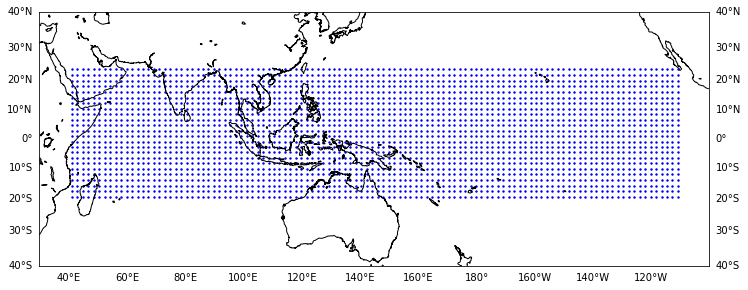

In [26]:
# Consider the entire monsoon region
monsoon_ocean_coords = []
for (i,j) in ocean_coords:
    if -20.<=i<= 25. and 40.<=j<=180.:
        monsoon_ocean_coords.append((i,j))
print(len(monsoon_ocean_coords))
monsoon_eep_ocean_coords = []
for (i,j) in ocean_coords:
    if -20.<=i<= 25. and -180.<=j<=-110.:
        monsoon_ocean_coords.append((i,j))
        
monsoon_land_coords = []
for (i,j) in land_coords:
    if -20.<=i<= 25. and 40.<=j<=180.:
        monsoon_land_coords.append((i,j))
print(len(monsoon_land_coords))
monsoon_eep_land_coords = []
for (i,j) in land_coords:
    if -20.<=i<= 25. and -180.<=j<=-110.:
        monsoon_land_coords.append((i,j))

monsoon_coords = monsoon_ocean_coords + monsoon_land_coords + monsoon_eep_ocean_coords + monsoon_eep_land_coords
monsoon = pd.DataFrame(monsoon_coords,columns=['Latitude','Longitude'])
monsoon_lat = monsoon['Latitude'].tolist()
monsoon_lon = monsoon['Longitude'].tolist()

monsoon_land_coords = monsoon_land_coords + monsoon_eep_land_coords
monsoon_land = pd.DataFrame(monsoon_land_coords,columns=['Latitude','Longitude'])

monsoon_ocean_coords = monsoon_ocean_coords + monsoon_eep_ocean_coords
monsoon_ocean = pd.DataFrame(monsoon_ocean_coords,columns=['Latitude','Longitude'])

plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=30,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,41.,10.),labels=[True,True,False,False],dashes=[2,2], linewidth=0.0)
m.drawmeridians(np.arange(20.,260.,20.),labels=[False,False,False,True],dashes=[2,2], linewidth=0.0)
m.scatter(monsoon_lon,monsoon_lat,latlon=True,s=2,c='blue')

#monsoon.to_csv('Total_Monsoon_Region_Coords.csv')
#monsoon_land.to_csv('Land_Monsoon_Region_Coords.csv')
#monsoon_ocean.to_csv('Ocean_Monsoon_Region_Coords.csv')

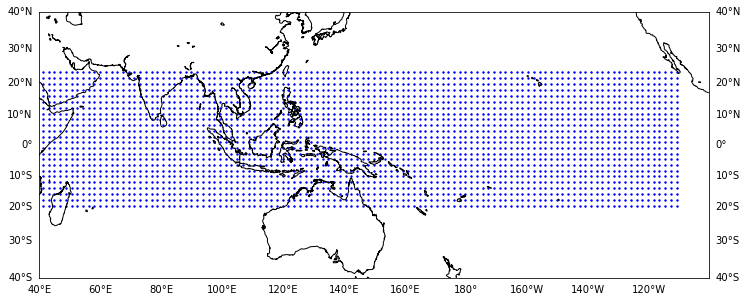

In [27]:
# Consider the entire monsoon region


monsoon_coords = monsoon_ocean_coords + monsoon_land_coords
monsoon = pd.DataFrame(monsoon_coords,columns=['Latitude','Longitude'])
monsoon_lat = monsoon['Latitude'].tolist()
monsoon_lon = monsoon['Longitude'].tolist()

plt.figure(figsize=(12,15));
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,41.,10.),labels=[True,True,False,False],dashes=[2,2], linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2], linewidth=0.0)
m.scatter(monsoon_lon,monsoon_lat,latlon=True,s=2,c='blue')

### Assign latitude/longitude indices to regions, find time series means across regions

In [28]:
# Assigning time series data to each of the areas in question
#print(use_ocean_index)

# Create index corresponding to each useful Latitude/Longitude combination
use_land_index = dict(zip(land_coords,[x for x in range(len(land_coords))]))
use_ocean_index = dict(zip(ocean_coords,[x for x in range(len(ocean_coords))]))
use_index = dict(zip(world_coords,[x for x in range(len(world_coords))]))


land_prec = land_prec() #Open land precipitation function to prepare for creating the index lists
ocean_prec = ocean_prec()
world_prec = world_prec()

100%|███████████████████████████████████████████████████████████████████████████| 18432/18432 [01:04<00:00, 285.51it/s]


In [29]:
# Land Prec
nw_aus_land_index = []
nw_aus_land_prec = []
for i in nw_aus_land_coords:
    nw_aus_land_index.append(use_land_index[i])
for i in nw_aus_land_index:
    nw_aus_land_prec.append(land_prec[i][2])
nw_aus_land_prec_mean = np.mean(nw_aus_land_prec,axis=0)

ne_aus_land_index = []
ne_aus_land_prec = []
for i in ne_aus_land_coords:
    ne_aus_land_index.append(use_land_index[i])
for i in ne_aus_land_index:
    ne_aus_land_prec.append(land_prec[i][2])
ne_aus_land_prec_mean = np.mean(ne_aus_land_prec,axis=0)
    
mc_land_index = []
mc_land_prec = []
for i in mc_land_coords:
    mc_land_index.append(use_land_index[i])
for i in mc_land_index:
    mc_land_prec.append(land_prec[i][2])
mc_land_prec_mean = np.mean(mc_land_prec,axis=0)

io_land_index = []
io_land_prec = []
for i in io_land_coords:
    io_land_index.append(use_land_index[i])
for i in io_land_index:
    io_land_prec.append(land_prec[i][2])
io_land_prec_mean = np.mean(io_land_prec,axis=0)    

ism_land_index = []
ism_land_prec = []
for i in ism_land_coords:
    ism_land_index.append(use_land_index[i])
for i in ism_land_index:
    ism_land_prec.append(land_prec[i][2])
ism_land_prec_mean = np.mean(ism_land_prec,axis=0)
    
easm_land_index = []
easm_land_prec = []
for i in easm_land_coords:
    easm_land_index.append(use_land_index[i])
for i in easm_land_index:
    easm_land_prec.append(land_prec[i][2])
easm_land_prec_mean = np.mean(easm_land_prec,axis=0)
    
eep_land_index = []
eep_land_prec = []
for i in eep_land_coords:
    eep_land_index.append(use_land_index[i])
for i in eep_land_index:
    eep_land_prec.append(land_prec[i][2])
eep_land_prec_mean = np.mean(eep_land_prec,axis=0)

# Ocean Prec
nw_aus_ocean_index = []
for i in nw_aus_ocean_coords:
    nw_aus_ocean_index.append(use_ocean_index[i])

ne_aus_ocean_index = []
for i in ne_aus_ocean_coords:
    ne_aus_ocean_index.append(use_ocean_index[i])

mc_ocean_index = []
for i in mc_ocean_coords:
    mc_ocean_index.append(use_ocean_index[i])
    
io_ocean_index = []
for i in io_ocean_coords:
    io_ocean_index.append(use_ocean_index[i])
    
ism_ocean_index = []
for i in ism_ocean_coords:
    ism_ocean_index.append(use_ocean_index[i])
    
easm_ocean_index = []
for i in easm_ocean_coords:
    easm_ocean_index.append(use_ocean_index[i])
    
eep_ocean_index = []
for i in eep_ocean_coords:
    eep_ocean_index.append(use_ocean_index[i])
    
nw_aus_ocean_prec = []
for i in nw_aus_ocean_index:
    nw_aus_ocean_prec.append(ocean_prec[i][2])
nw_aus_ocean_prec_mean = np.mean(nw_aus_ocean_prec,axis=0)
    
ne_aus_ocean_prec = []
for i in ne_aus_ocean_index:
    ne_aus_ocean_prec.append(ocean_prec[i][2])
ne_aus_ocean_prec_mean = np.mean(ne_aus_ocean_prec,axis=0)
    
mc_ocean_prec = []
for i in mc_ocean_index:
    mc_ocean_prec.append(ocean_prec[i][2])
mc_ocean_prec_mean = np.mean(mc_ocean_prec,axis=0)
    
io_ocean_prec = []
for i in io_ocean_index:
    io_ocean_prec.append(ocean_prec[i][2])
io_ocean_prec_mean = np.mean(io_ocean_prec,axis=0)
    
ism_ocean_prec = []
for i in ism_ocean_index:
    ism_ocean_prec.append(ocean_prec[i][2])
ism_ocean_prec_mean = np.mean(ism_ocean_prec,axis=0)
    
easm_ocean_prec = []
for i in easm_ocean_index:
    easm_ocean_prec.append(ocean_prec[i][2])
easm_ocean_prec_mean = np.mean(easm_ocean_prec,axis=0)

eep_ocean_prec = []
for i in eep_ocean_index:
    eep_ocean_prec.append(ocean_prec[i][2])
eep_ocean_prec_mean = np.mean(eep_ocean_prec,axis=0)

# TOTAL DATA LAND AND SEA
nw_aus_index = []
for i in nw_aus_coords:
    nw_aus_index.append(use_index[i])

ne_aus_index = []
for i in ne_aus_coords:
    ne_aus_index.append(use_index[i])

mc_index = []
for i in mc_coords:
    mc_index.append(use_index[i])
    
io_index = []
for i in io_coords:
    io_index.append(use_index[i])
    
ism_index = []
for i in ism_coords:
    ism_index.append(use_index[i])
    
easm_index = []
for i in easm_coords:
    easm_index.append(use_index[i])
    
eep_index = []
for i in eep_coords:
    eep_index.append(use_index[i])
    
nw_aus_prec = []
for i in nw_aus_index:
    nw_aus_prec.append(world_prec[i][2])
nw_aus_prec_mean = np.mean(nw_aus_prec,axis=0)
    
ne_aus_prec = []
for i in ne_aus_index:
    ne_aus_prec.append(world_prec[i][2])
ne_aus_prec_mean = np.mean(ne_aus_prec,axis=0)
    
mc_prec = []
for i in mc_index:
    mc_prec.append(world_prec[i][2])
mc_prec_mean = np.mean(mc_prec,axis=0)
    
io_prec = []
for i in io_index:
    io_prec.append(world_prec[i][2])
io_prec_mean = np.mean(io_prec,axis=0)
    
ism_prec = []
for i in ism_index:
    ism_prec.append(world_prec[i][2])
ism_prec_mean = np.mean(ism_prec,axis=0)
    
easm_prec = []
for i in easm_index:
    easm_prec.append(world_prec[i][2])
easm_prec_mean = np.mean(easm_prec,axis=0)

eep_prec = []
for i in eep_index:
    eep_prec.append(world_prec[i][2])
eep_prec_mean = np.mean(eep_prec,axis=0)

# Save to csv
land_compiled = pd.DataFrame(list(zip(final_times_all,
                                      nw_aus_land_prec_mean,
                                      ne_aus_land_prec_mean,
                                      mc_land_prec_mean,
                                      io_land_prec_mean,
                                      ism_land_prec_mean,
                                      easm_land_prec_mean)), # EEP does not exist on land...
                             columns=['Date','NW_Aus_Land_Prec_Mean','NE_Aus_Land_Prec_Mean','MC_Land_Prec_Mean','IO_Land_Prec_Mean','ISM_Land_Prec_Mean','EASM_Land_Prec_Mean'])
ocean_compiled = pd.DataFrame(list(zip(final_times_all,
                                       nw_aus_ocean_prec_mean,
                                       ne_aus_ocean_prec_mean,
                                       mc_ocean_prec_mean,
                                       io_ocean_prec_mean,
                                       ism_ocean_prec_mean,
                                       easm_ocean_prec_mean,
                                       eep_ocean_prec_mean)),
                              columns=['Date','NW_Aus_Ocean_Prec_Mean','NE_Aus_Ocean_Prec_Mean','MC_Land_Prec_Mean','IO_Ocean_Prec_Mean','ISM_Ocean_Prec_Mean','EASM_Ocean_Prec_Mean','EEP_Land_Prec_Mean'])
all_compiled = pd.DataFrame(list(zip(final_times_all,
                                     nw_aus_prec_mean,
                                     ne_aus_prec_mean,
                                     mc_prec_mean,
                                     io_prec_mean,
                                     ism_prec_mean,
                                     easm_prec_mean,
                                     eep_prec_mean)),
                            columns=['Date','NW_Aus_Prec_Mean','NE_Aus_Prec_Mean','MC_Prec_Mean','IO_Prec_Mean','ISM_Prec_Mean','EASM_Prec_Mean','EEP_Prec_Mean'])

C:\Users\Owner\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Owner\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
land_compiled

,Date,NW_Aus_Land_Prec_Mean,NE_Aus_Land_Prec_Mean,MC_Land_Prec_Mean,IO_Land_Prec_Mean,ISM_Land_Prec_Mean,EASM_Land_Prec_Mean
0,16-01-1611,243.178161,181.272542,158.985655,80.889214,127.727657,40.474318
1,16-02-1611,225.791323,221.780444,181.297031,104.560966,105.644383,21.019179
2,16-03-1611,147.424828,167.785236,223.069454,86.141586,66.410755,23.264497
3,16-04-1611,71.469421,118.350910,259.480080,68.467018,85.238559,48.805252
4,16-05-1611,28.398838,59.576635,210.491838,47.467491,111.672090,126.505649
...,...,...,...,...,...,...,...
4711,16-08-2003,28.622667,51.121593,99.421766,10.463623,224.596132,238.272710
4712,16-09-2003,46.599551,59.689472,110.805780,18.812057,199.016530,162.289293
4713,16-10-2003,107.858366,73.208878,139.846372,32.655975,157.152725,246.027543
4714,16-11-2003,208.847911,138.763192,162.203162,102.786957,150.668636,184.207018


In [31]:
len(mc_land_prec_mean)

4716

In [32]:
len(nw_aus_land_prec_mean)

4716

In [33]:
# Total monsoon region
monsoon_index = []
for i in monsoon_coords:
    monsoon_index.append(use_index[i])
monsoon_prec = []
for i in monsoon_index:
    monsoon_prec.append(world_prec[i][2])
monsoon_coords[0]

(23.32, 60.0)

In [34]:
monsoon_dict = list(zip(monsoon_lat, monsoon_lon,monsoon_prec))
columns = ['Data' for x in range(len(monsoon_dict))]
df = pd.DataFrame(monsoon_dict)
df

,0,1,2
0,23.32,60.000,"[42.308353424072266, 37.75973892211914, 37.527..."
1,23.32,61.875,"[41.14006805419922, 36.226524353027344, 31.670..."
2,23.32,63.750,"[39.16463851928711, 36.59400177001953, 24.3609..."
3,23.32,65.625,"[34.581546783447266, 38.010826110839844, 20.02..."
4,23.32,67.500,"[34.74210739135742, 45.1760139465332, 20.96620..."
...,...,...,...
2683,-19.59,142.500,"[199.56639099121094, 235.01815795898438, 153.9..."
2684,-19.59,144.375,"[213.49887084960938, 244.83248901367188, 184.5..."
2685,-19.59,146.250,"[185.98736572265625, 211.36114501953125, 193.8..."
2686,19.59,-155.625,"[-0.00013784396287519485, 0.2612995207309723, ..."


In [ ]:
df.to_csv(r'C:\Users\Owner\Documents\Thesis\Exploration\Total_Monsoon_Region\total_monsoon_prec.csv')

In [ ]:
df1 = pd.DataFrame(final_times_all)
df1.to_csv(r'C:\Users\Owner\Documents\Thesis\Exploration\Total_Monsoon_Region\times.csv')

In [ ]:
land_compiled.to_csv('Land_Prec_Mean_by_Region.csv')
ocean_compiled.to_csv('Ocean_Prec_Mean_by_Region.csv')
#all_compiled.to_csv('Prec_Mean_by_Region.csv')

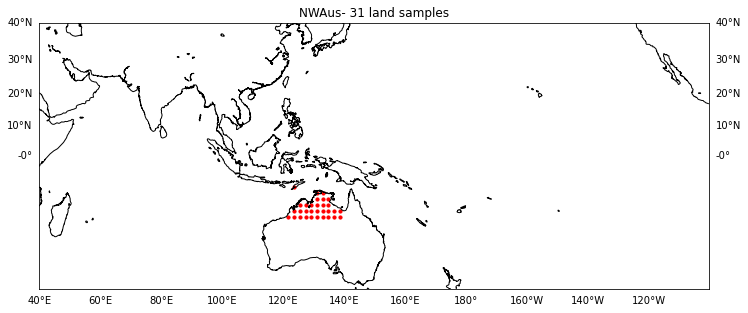

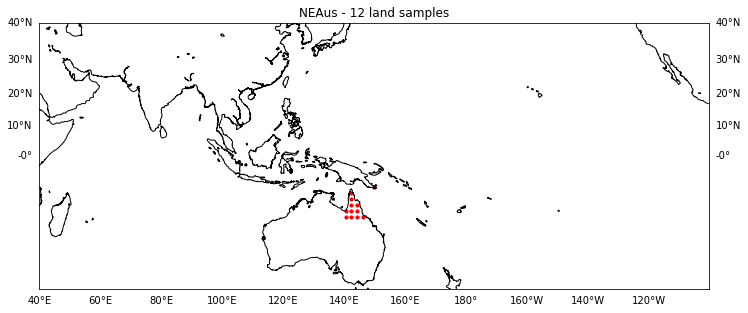

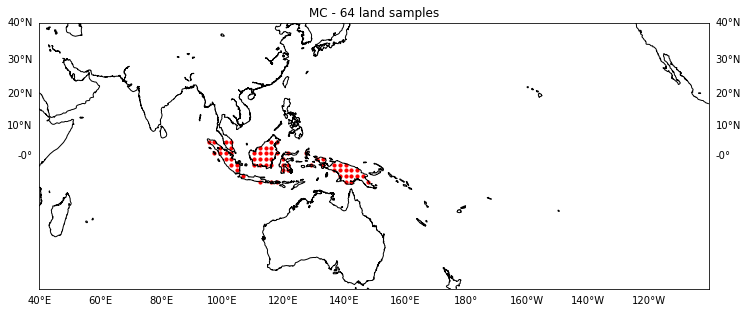

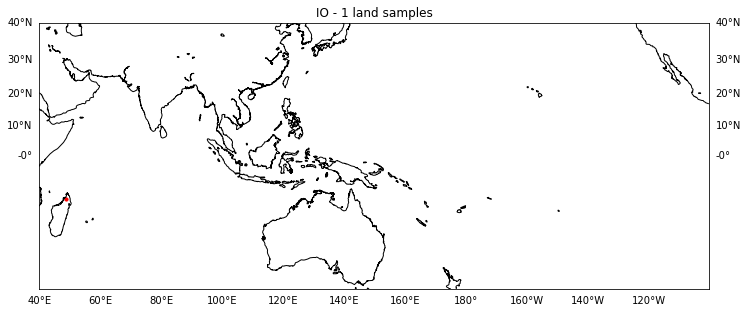

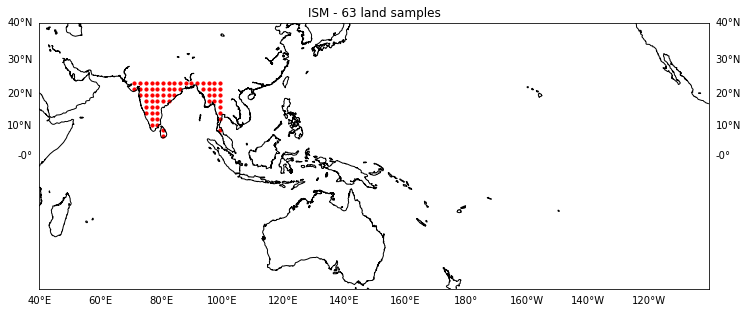

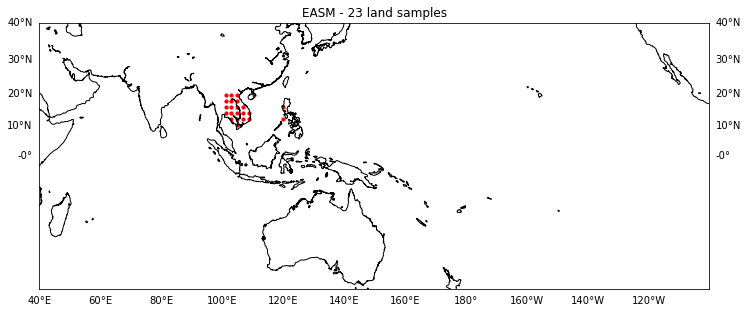

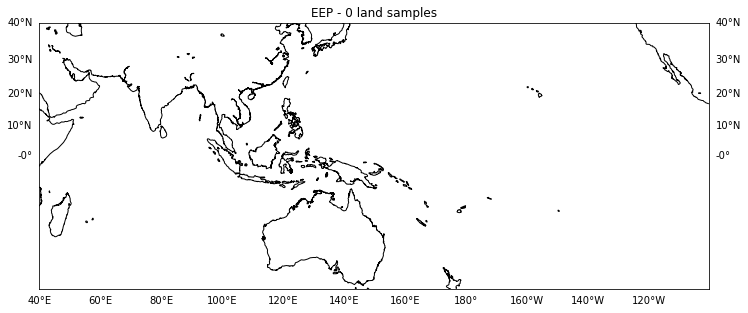

In [35]:
# Land Samples

plt.figure(figsize=(12,15));
plt.title(f'NWAus- {len(nw_aus_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(nw_aus_land_lon,nw_aus_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'NEAus - {len(ne_aus_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ne_aus_land_lon,ne_aus_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'MC - {len(mc_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(mc_land_lon,mc_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'IO - {len(io_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(io_land_lon,io_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'ISM - {len(ism_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ism_land_lon,ism_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EASM - {len(easm_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(easm_land_lon,easm_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EEP - {len(eep_land_coords)} land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(eep_land_lon,eep_land_lat,latlon=True,s=10,c='red')

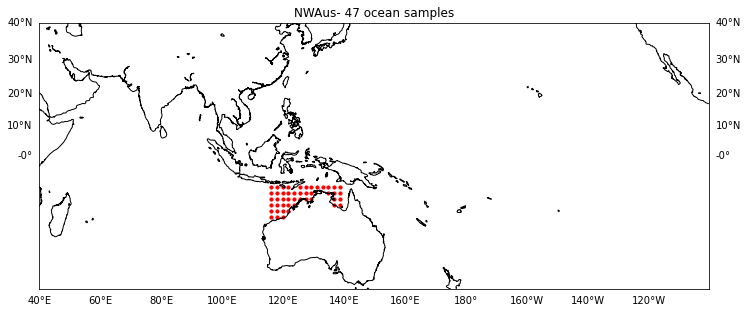

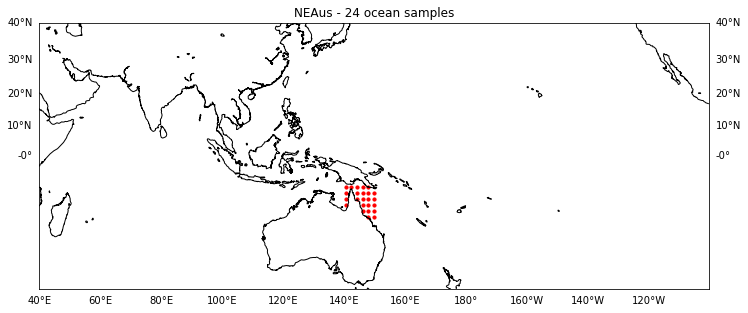

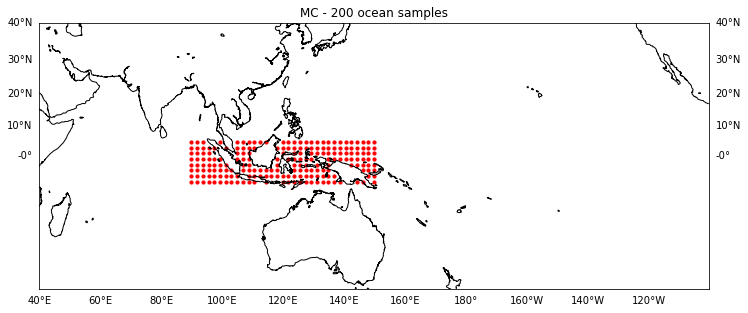

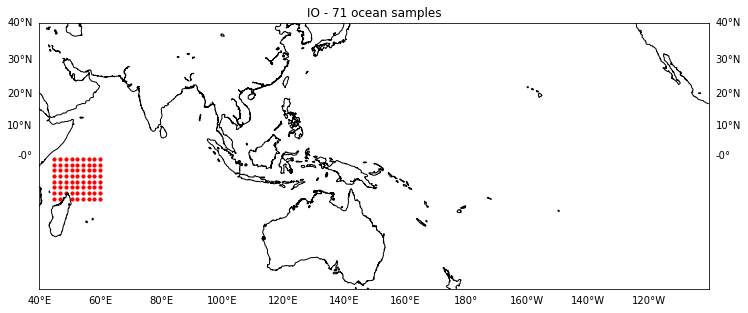

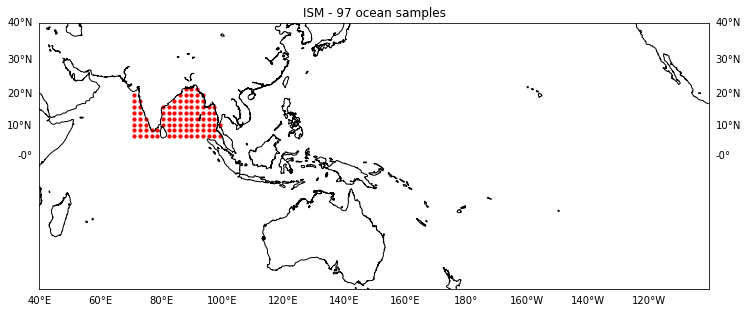

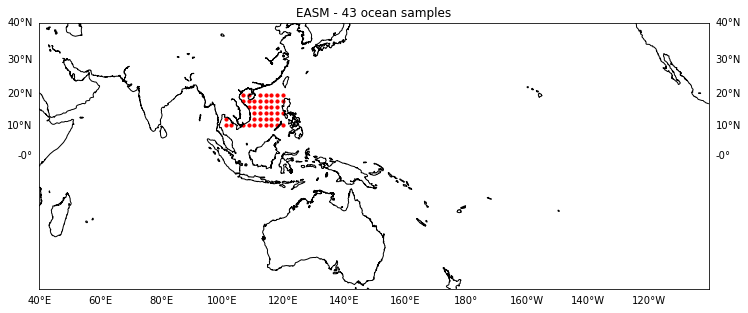

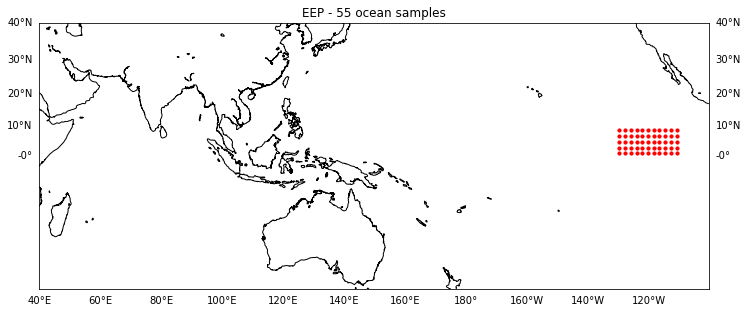

In [36]:
# Ocean points

plt.figure(figsize=(12,15));
plt.title(f'NWAus- {len(nw_aus_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(nw_aus_ocean_lon,nw_aus_ocean_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'NEAus - {len(ne_aus_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ne_aus_ocean_lon,ne_aus_ocean_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'MC - {len(mc_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(mc_ocean_lon,mc_ocean_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'IO - {len(io_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(io_ocean_lon,io_ocean_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'ISM - {len(ism_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ism_ocean_lon,ism_ocean_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EASM - {len(easm_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(easm_ocean_lon,easm_ocean_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EEP - {len(eep_ocean_coords)} ocean samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(eep_ocean_lon,eep_ocean_lat,latlon=True,s=10,c='red')

In [ ]:
# All points

plt.figure(figsize=(12,15));
plt.title(f'NWAus- {len(nw_aus_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(nw_aus_ocean_lon+nw_aus_land_lon,nw_aus_ocean_lat+nw_aus_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'NEAus - {len(ne_aus_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ne_aus_ocean_lon+ne_aus_land_lon,ne_aus_ocean_lat+ne_aus_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'MC - {len(mc_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(mc_ocean_lon+mc_land_lon,mc_ocean_lat+mc_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'IO - {len(io_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(io_ocean_lon+io_land_lon,io_ocean_lat+io_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'ISM - {len(ism_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(ism_ocean_lon+ism_land_lon,ism_ocean_lat+ism_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EASM - {len(easm_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(easm_ocean_lon+easm_land_lon,easm_ocean_lat+easm_land_lat,latlon=True,s=10,c='red')

plt.figure(figsize=(12,15));
plt.title(f'EEP - {len(eep_ocean_coords)} all samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(eep_ocean_lon+eep_land_lon,eep_ocean_lat+eep_land_lat,latlon=True,s=10,c='red')

In [ ]:
plt.figure(figsize=(12,15));
plt.title(f'All land samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
parallel_ticks = np.arange(-40.,41.,10.)
parallel_labels = labels=[]
for i in parallel_ticks:
    parallel_labels.append(True)
m.drawparallels(parallel_ticks,dashes=[5,4],linewidth=0.0,labels=labels)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(nw_aus_ocean_lon+nw_aus_land_lon,nw_aus_ocean_lat+nw_aus_land_lat,latlon=True,s=10,c='r',marker='o',label=r'NW_Aus')
m.scatter(ne_aus_ocean_lon+ne_aus_land_lon,ne_aus_ocean_lat+ne_aus_land_lat,latlon=True,s=10,c='g',marker='v',label=r'NE_Aus')
m.scatter(mc_ocean_lon+mc_land_lon,mc_ocean_lat+mc_land_lat,latlon=True,s=10,c='b',marker='s', label=r'MC')
m.scatter(io_ocean_lon+io_land_lon,io_ocean_lat+io_land_lat,latlon=True,s=10,c='y',marker='*', label=r'IO')
m.scatter(ism_ocean_lon+ism_land_lon,ism_ocean_lat+ism_land_lat,latlon=True,s=10,c='red',marker='X', label=r'ISM')
m.scatter(easm_ocean_lon+easm_land_lon,easm_ocean_lat+easm_land_lat,latlon=True,s=10,c='y', label=r'EASM')
m.scatter(eep_ocean_lon+eep_land_lon,eep_ocean_lat+eep_land_lat,latlon=True,s=10,c='red', label=r'EEP')
plt.legend(loc='lower right')

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

patches = []

nw = np.array([[115,-20],[140,-20],[140,-10],[115,-10]])
ne = np.array([[140,-20],[150,-20],[150,-10],[140,-10]])
mc = np.array([[90,-10],[150,-10],[150,5],[90,5]])
io = np.array([[45,-15],[60,-15],[60,0],[45,0]])
ism = np.array([[70,5],[100,5],[100,25],[70,25]])
easm = np.array([[100,10],[120,10],[120,20],[100,20]])
eep = np.array([[230,0],[250,0],[250,10],[230,10]])

patches.append(Polygon(nw))
patches.append(Polygon(ne))
patches.append(Polygon(mc))
patches.append(Polygon(io))
patches.append(Polygon(ism))
patches.append(Polygon(easm))
patches.append(Polygon(eep))
               
fig = plt.figure(figsize=(10,20));
ax=fig.add_axes([0.1,0.1,1,2])
m = Basemap(projection = 'cyl', llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
#m = Basemap(projection = 'merc', llcrnrlat=-80,llcrnrlon=-180,urcrnrlat=80,urcrnrlon=180, resolution='c')
m.drawcoastlines()
parallel_ticks = np.arange(-40.,41.,10.)
parallel_labels = labels=[]
for i in parallel_ticks:
    parallel_labels.append(True)
m.drawparallels(parallel_ticks,dashes=[5,4],linewidth=0.0,labels=labels)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
ax.add_collection(PatchCollection(patches, facecolor='grey', edgecolor='k', linewidths=0.5))
m.scatter(average_lon,average_lat,latlon=True,s=150,c='blue')

In [ ]:
fig = plt.figure(figsize=(10,20));
ax=fig.add_axes([0.1,0.1,1,2])

m = Basemap(projection='cyl',llcrnrlat=-40,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')

m.drawcoastlines()

patches = []
#zone_A = np.array([[-20,140],[-10,140],[-10,115],[-20,115]])
nw = np.array([[115,-20],[140,-20],[140,-10],[115,-10]])
ne = np.array([[140,-20],[150,-20],[150,-10],[140,-10]])
mc = np.array([[90,-10],[150,-10],[150,5],[90,5]])
io = np.array([[45,-15],[60,-15],[60,0],[45,0]])
ism = np.array([[70,5],[100,5],[100,25],[70,25]])
easm = np.array([[100,10],[120,10],[120,20],[100,20]])
eep = np.array([[230,0],[250,0],[250,10],[230,10]])

patches.append(Polygon(nw))
patches.append(Polygon(ne))
patches.append(Polygon(mc))
patches.append(Polygon(io))
patches.append(Polygon(ism))
patches.append(Polygon(easm))
patches.append(Polygon(eep))

ax.add_collection(PatchCollection(patches, facecolor='silver', edgecolor='k', linewidths=0.5))
#ax.add_collection(PatchCollection(test, facecolor='lightgreen', edgecolor='k', linewidths=0.5))

parallel_ticks = np.arange(-40.,41.,10.)
parallel_labels = labels=[]
for i in parallel_ticks:
    parallel_labels.append(True)
m.drawparallels(parallel_ticks,dashes=[5,4],linewidth=0.0,labels=labels)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(average_lon,average_lat,latlon=True,s=150,c='blue')

In [ ]:
test = ['NWAus','NEAus','MC','IO','ISM','EASM','EEP']

fig = plt.figure(figsize=(10,20));
ax=fig.add_axes([0.1,0.1,1,2])

m = Basemap(projection='cyl',llcrnrlat=-50,llcrnrlon=40,urcrnrlat=40,urcrnrlon=255, resolution='l')

m.drawcoastlines(linewidth=0.3)
m.drawmapboundary(fill_color='aqua',linewidth=0.5)
m.fillcontinents(color='coral',lake_color='aqua')

patches = []
#zone_A = np.array([[-20,140],[-10,140],[-10,115],[-20,115]])
nw = np.array([[115,-20],[140,-20],[140,-10],[115,-10]])
ne = np.array([[140,-20],[150,-20],[150,-10],[140,-10]])
mc = np.array([[90,-10],[150,-10],[150,5],[90,5]])
io = np.array([[45,-15],[60,-15],[60,0],[45,0]])
ism = np.array([[70,5],[100,5],[100,25],[70,25]])
easm = np.array([[100,10],[120,10],[120,20],[100,20]])
eep = np.array([[230,0],[250,0],[250,10],[230,10]])

patches.append(Polygon(nw))
patches.append(Polygon(ne))
patches.append(Polygon(mc))
patches.append(Polygon(io))
patches.append(Polygon(ism))
patches.append(Polygon(easm))
patches.append(Polygon(eep))

ax.add_collection(PatchCollection(patches, facecolor='none', edgecolor='k', linewidths=1.5,ls='dashed'))

parallel_ticks = np.arange(-40.,41.,10.)
parallel_labels = labels=[]
for i in parallel_ticks:
    parallel_labels.append(True)
m.drawparallels(parallel_ticks,dashes=[5,4],linewidth=0.0,labels=labels)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
#m.scatter(average_lon,average_lat,latlon=True,s=150,c='blue')
for i, txt in enumerate(average_lon):
    ax.annotate(test[i], (average_lon[i], average_lat[i]), ha="center", va="center",color='white',bbox=dict(boxstyle="round", fc="k", lw=1))
    
plt.savefig('regions.png')

## Extracting Data from Uncoupled Continental Region

In [ ]:
## South-West WA (note not the best)
# Note the interactions with the monsoon outflow discussed in:
#"In situ measurement of seasonal d18O variations and analysis of isotopic trends in a modern speleothem from southwest Australia"
moondyne_cave = [115.08,-34.27]

sw_aus_land_coords = []
for (i,j) in land_coords:
    if -34.27-7.5<=i<= -34.27+2.5 and 115.08-7.5<=j<=115.08+7.5:
        sw_aus_land_coords.append((i,j))
sw_aus_land_lat = []
sw_aus_land_lon = []
for (i,j) in sw_aus_land_coords:
    sw_aus_land_lat.append(i)
    sw_aus_land_lon.append(j)

sw_aus_ocean_coords = []
for (i,j) in ocean_coords:
    if -34.27-7.5<=i<= -34.27+2.5 and 115.08-7.5<=j<=115.08+7.5:
        sw_aus_ocean_coords.append((i,j))
sw_aus_ocean_lat = []
sw_aus_ocean_lon = []
for (i,j) in sw_aus_ocean_coords:
    sw_aus_ocean_lat.append(i)
    sw_aus_ocean_lon.append(j)

sw_aus_lon = sw_aus_ocean_lon+sw_aus_land_lon
sw_aus_lat = sw_aus_ocean_lat+sw_aus_land_lat
sw_aus_coords = list(zip(sw_aus_lat,sw_aus_lon))

sw_aus = pd.DataFrame(list(zip(sw_aus_lat,sw_aus_lon)),columns=['Latitude','Longitude'])

plt.figure(figsize=(12,15));
plt.title(f'SWAus- {len(sw_aus_coords)} samples, {len(sw_aus_land_coords)} land coords & {len(sw_aus_ocean_coords)} ocean coords')
m = Basemap(projection = 'merc', llcrnrlat=-45,llcrnrlon=40,urcrnrlat=40,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-0.,41.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(sw_aus_lon,sw_aus_lat,latlon=True,s=10,c='red')

sw_aus_index = []
for i in sw_aus_coords:
    sw_aus_index.append(use_index[i])
    
sw_aus_prec = []
for i in sw_aus_index:
    sw_aus_prec.append(world_prec[i][2])
sw_aus_prec_mean = np.mean(sw_aus_prec,axis=0)

In [ ]:
# Moscow
lat_min = 40
lat_max = 50
lon_min = 35
lon_max = 50

moscow_land_coords = []
for (i,j) in land_coords:
    if lat_min<=i<= lat_max and lon_min<=j<=lon_max:
        moscow_land_coords.append((i,j))
moscow_land_lat = []
moscow_land_lon = []
for (i,j) in moscow_land_coords:
    moscow_land_lat.append(i)
    moscow_land_lon.append(j)

moscow_ocean_coords = []
for (i,j) in ocean_coords:
    if lat_min<=i<= lat_max and lon_min<=j<=lon_max:
        moscow_ocean_coords.append((i,j))
moscow_ocean_lat = []
moscow_ocean_lon = []
for (i,j) in moscow_ocean_coords:
    moscow_ocean_lat.append(i)
    moscow_ocean_lon.append(j)

moscow_lon = moscow_ocean_lon+moscow_land_lon
moscow_lat = moscow_ocean_lat+moscow_land_lat
moscow_coords = list(zip(moscow_lat,moscow_lon))

moscow = pd.DataFrame(list(zip(moscow_lat,moscow_lon)),columns=['Latitude','Longitude'])

plt.figure(figsize=(12,15));
plt.title(f'Moscow- {len(moscow_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-40,llcrnrlon=20,urcrnrlat=60,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,81.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(moscow_lon,moscow_lat,latlon=True,s=10,c='red')

moscow_index = []
for i in moscow_coords:
    moscow_index.append(use_index[i])
    
moscow_prec = []
for i in moscow_index:
    moscow_prec.append(world_prec[i][2])
moscow_prec_mean = np.mean(moscow_prec,axis=0)

In [ ]:
# Poland
lat_min = 49
lat_max = 55
lon_min = 14
lon_max = 24

poland_land_coords = []
for (i,j) in land_coords:
    if lat_min<=i<= lat_max and lon_min<=j<=lon_max:
        poland_land_coords.append((i,j))
poland_land_lat = []
poland_land_lon = []
for (i,j) in poland_land_coords:
    poland_land_lat.append(i)
    poland_land_lon.append(j)

poland_ocean_coords = []
for (i,j) in ocean_coords:
    if lat_min<=i<= lat_max and lon_min<=j<=lon_max:
        poland_ocean_coords.append((i,j))
poland_ocean_lat = []
poland_ocean_lon = []
for (i,j) in poland_ocean_coords:
    poland_ocean_lat.append(i)
    poland_ocean_lon.append(j)

poland_lon = poland_ocean_lon+poland_land_lon
poland_lat = poland_ocean_lat+poland_land_lat
poland_coords = list(zip(poland_lat,poland_lon))

poland = pd.DataFrame(list(zip(poland_lat,poland_lon)),columns=['Latitude','Longitude'])

plt.figure(figsize=(12,15));
plt.title(f'poland- {len(poland_coords)} samples')
m = Basemap(projection = 'merc', llcrnrlat=-10,llcrnrlon=10,urcrnrlat=60,urcrnrlon=260, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-40.,81.,10.),labels=[True,True,False,False],dashes=[2,2],linewidth=0.0)
m.drawmeridians(np.arange(40.,260.,20.),labels=[False,False,False,True],dashes=[2,2],linewidth=0.0)
m.scatter(poland_lon,poland_lat,latlon=True,s=10,c='red')

poland_index = []
for i in poland_coords:
    poland_index.append(use_index[i])
    
poland_prec = []
for i in poland_index:
    poland_prec.append(world_prec[i][2])
poland_prec_mean = np.mean(poland_prec,axis=0)

In [ ]:
uncoupled = pd.DataFrame(zip(final_times_all,
                             sw_aus_prec_mean,
                             moscow_prec_mean,
                             poland_prec_mean),
                         columns=['Date','SW_Aus','Moscow','Poland'])
uncoupled.to_csv('Uncoupled_Regions_Prec_Mean.csv')